In [ ]:
#https://learnopencv.com/kerascv-deeplabv3-plus-semantic-segmentation/
#Teeth Segmentation using DeepLabV3 Plus
!pip install -q git+https://github.com/keras-team/keras-cv.git --upgrade


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 11.5 MB/s eta 0:00:00


In [ ]:
import os
import requests
from zipfile import ZipFile
import glob
from dataclasses import dataclass

import random
import numpy as np
import cv2

import tensorflow as tf
import keras_cv

import matplotlib.pyplot as plt

Using TensorFlow backend


In [ ]:
def system_config(SEED_VALUE):
    # Set python `random` seed.
    # Set `numpy` seed
    # Set `tensorflow` seed.
    random.seed(SEED_VALUE)
    tf.keras.utils.set_random_seed(SEED_VALUE)
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_USE_CUDNN'] = "true"

system_config(SEED_VALUE=42)

In [ ]:
@dataclass(frozen=True)
class data_config:
    IMAGE_SIZE:        tuple = (256, 256)
    BATCH_SIZE:          int = 16
    NUM_CLASSES:         int = 2
    BRIGHTNESS_FACTOR: float = 0.2
    CONTRAST_FACTOR:   float = 0.2

In [ ]:
@dataclass(frozen=True)
class train_config:
    MODEL:           str = "efficientnetv2_b2_imagenet"
    EPOCHS:          int = 35
    LEARNING_RATE: float = 1e-4
    CKPT_DIR:        str = os.path.join("checkpoints_"+"_".join(MODEL.split("_")[:2]),
                                        "deeplabv3_plus_run1_"+"_".join(MODEL.split("_")[:2])+".weights.h5")
    LOGS_DIR:        str = "logs_"+"_".join(MODEL.split("_")[:2])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATASET_DIR_IMG = '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/'
DATASET_DIR_MASK = '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/'
#data_images = glob.glob(os.path.join(DATASET_DIR_IMG, "Images", "*.jpg"))
#data_masks = glob.glob(os.path.join(DATASET_DIR_MASK, "Masks", "*.jpg"))
path = ''
image_path = os.path.join(path, '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/Images/')
mask_path = os.path.join(path, '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/Masks/')
image_list_orig = os.listdir(image_path)
data_images = sorted([image_path+i for i in image_list_orig])
data_masks = sorted([mask_path+i for i in image_list_orig])
# Shuffle the data paths before data preparation.
zipped_data = list(zip(data_images, data_masks))
random.shuffle(zipped_data)
data_images, data_masks = zip(*zipped_data)
data_images = list(data_images)
data_masks = list(data_masks)
print(data_images)
print(data_masks)

['/content/drive/MyDrive/CS230_Project/Dental_DB/Data/Images/788.jpg', '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/Images/536.jpg', '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/Images/90.jpg', '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/Images/924.jpg', '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/Images/1037.jpg', '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/Images/512.jpg', '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/Images/143.jpg', '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/Images/764.jpg', '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/Images/393.jpg', '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/Images/550.jpg', '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/Images/233.jpg', '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/Images/819.jpg', '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/Images/453.jpg', '/content/drive/MyDrive/CS230_Project/Dental_DB/Data/Images/635.jpg', '/content/drive/MyD

In [ ]:
org_data = tf.data.Dataset.from_tensor_slices((data_images, data_masks))


In [ ]:
SPLIT_RATIO = 0.1
# Determine the number of validation samples
NUM_VAL = int(len(data_images) * SPLIT_RATIO)

# Split the dataset into train and validation sets
train_data = org_data.skip(NUM_VAL)
valid_data = org_data.take(NUM_VAL)

In [ ]:
def read_image_mask(image_path, mask=False, size = data_config.IMAGE_SIZE):
    image = tf.io.read_file(image_path)

    if mask:

        image = tf.io.decode_image(image, channels=3)
        image = tf.math.reduce_max(image, axis=-1, keepdims=True)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=size, method = "bicubic")

        image_mask = tf.zeros_like(image)
        cond = image >=200
        updates = tf.ones_like(image[cond])
        image_mask = tf.tensor_scatter_nd_update(image_mask, tf.where(cond), updates)
        image = tf.cast(image_mask, tf.uint8)

    else:
        image = tf.io.decode_image(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=size, method = "bicubic")
        image = tf.cast(tf.clip_by_value(image, 0., 255.), tf.float32)

    return image

In [ ]:
def load_data(image_list, mask_list):
    image = read_image_mask(image_list)
    mask  = read_image_mask(mask_list, mask=True)
    return {"images":image, "segmentation_masks":mask}

In [ ]:
train_ds = train_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
def unpackage_inputs(inputs):
    images = inputs["images"]
    segmentation_masks = inputs["segmentation_masks"]
    return images, segmentation_masks

In [ ]:
id2color = {
    0: (0,  0,    0),    # Background
    1: (255, 255, 255),  # Teeth
 }

In [ ]:
def num_to_rgb(num_arr, color_map=id2color):

    # single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2]+(3,))

    for k in color_map.keys():
        output[num_arr==k] = color_map[k]

    return output.astype(np.uint8)

In [ ]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):

    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.

    image = image.astype(np.uint8)

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

In [ ]:
def display_image_and_mask(data_list, title_list, figsize, color_mask=False, color_map=id2color):

    # Create RGB segmentation map from grayscale segmentation map.
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)
    mask_to_overlay = rgb_gt_mask

    if len(data_list)==3:
        rgb_pred_mask = num_to_rgb(data_list[-1], color_map=color_map)
        mask_to_overlay = rgb_pred_mask

    # Create the overlayed image.
    overlayed_image = image_overlay(data_list[0], mask_to_overlay)

    data_list.append(overlayed_image)

    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)

    for idx, axis in enumerate(axes.flat):
        axis.set_title(title_list[idx])
        if title_list[idx] == "GT Mask":
            if color_mask:
                axis.imshow(rgb_gt_mask)
            else:
                axis.imshow(data_list[1], cmap="gray")

        elif title_list[idx] == "Pred Mask":
            if color_mask:
                axis.imshow(rgb_pred_mask)
            else:
                axis.imshow(data_list[-1], cmap="gray")

        else:
            axis.imshow(data_list[idx])

        axis.axis('off')

    plt.show()

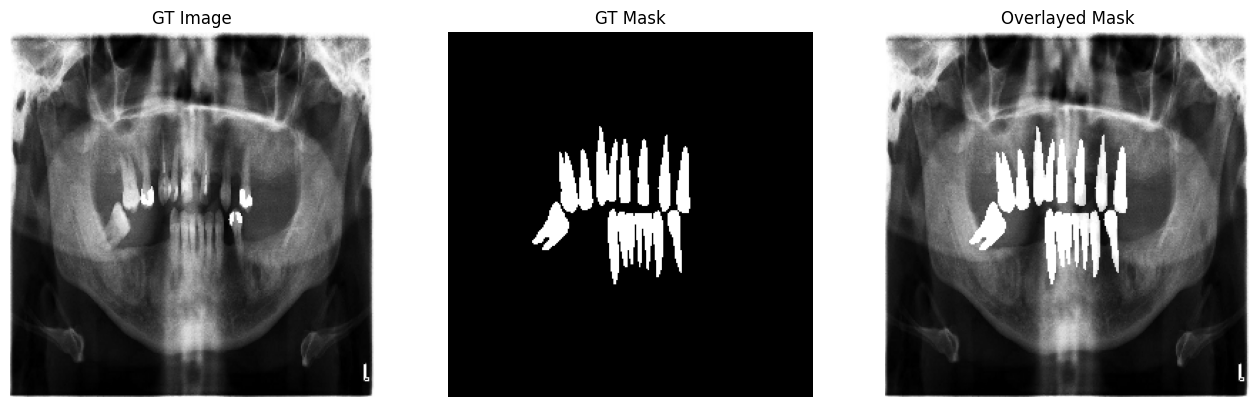

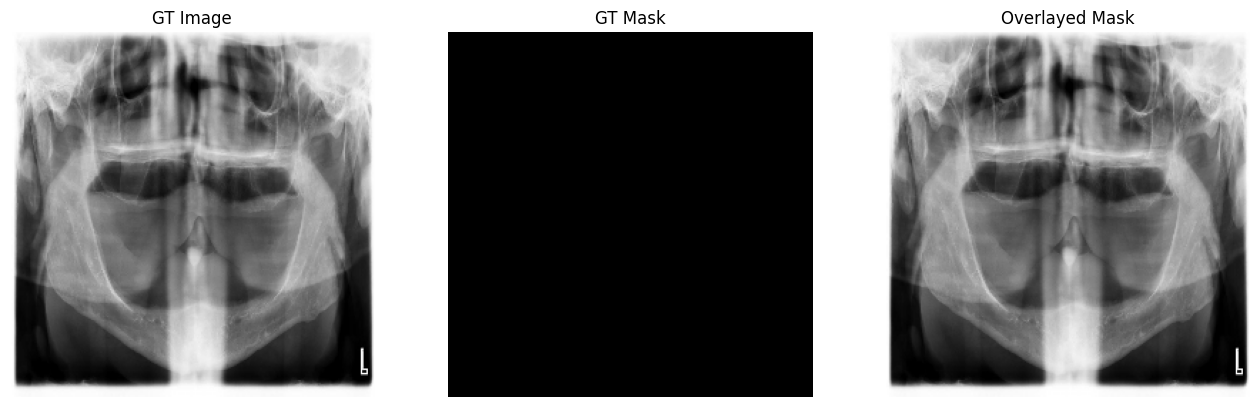

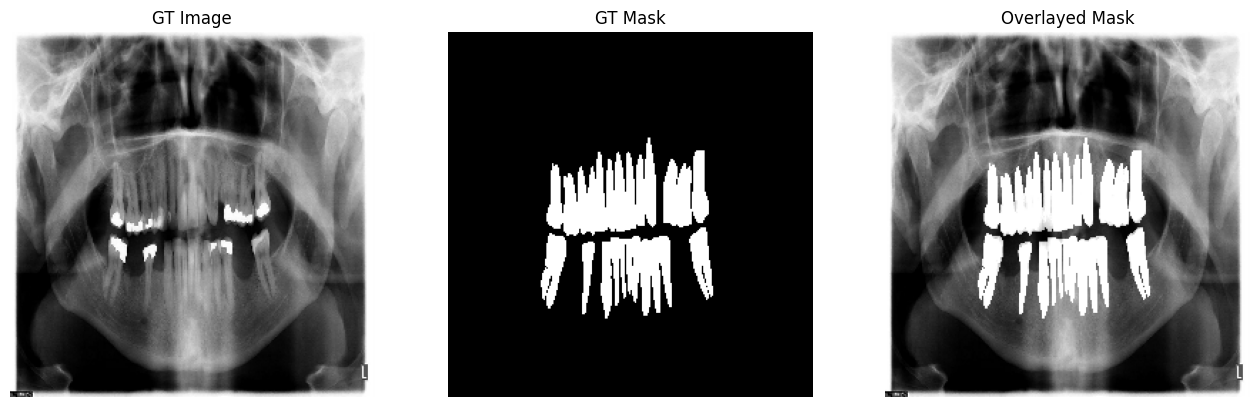

In [ ]:
plot_train_ds = train_ds.map(unpackage_inputs).batch(3)
image_batch, mask_batch = next(iter(plot_train_ds.take(1)))

titles = ["GT Image", "GT Mask", "Overlayed Mask"]

for image, gt_mask in zip(image_batch, mask_batch):

    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask([image.numpy().astype(np.uint8), gt_mask],
                           title_list=titles,
                           figsize=(16,6),
                           color_mask=True)

In [ ]:
augment_fn = tf.keras.Sequential(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandomBrightness(factor=data_config.BRIGHTNESS_FACTOR,
                                         value_range=(0, 255)),
        keras_cv.layers.RandomContrast(factor=data_config.CONTRAST_FACTOR,
                                       value_range=(0, 255)),
    ]
)

In [ ]:
train_dataset = (
                train_ds.shuffle(data_config.BATCH_SIZE)
                .map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(data_config.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

valid_dataset = (
                valid_ds.batch(data_config.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
backbone = keras_cv.models.ResNet50V2Backbone.from_preset(preset = train_config.MODEL,
                                                          input_shape=data_config.IMAGE_SIZE+(3,),
                                                          load_weights = True)
model = keras_cv.models.segmentation.DeepLabV3Plus(
        num_classes=data_config.NUM_CLASSES, backbone=backbone,
    )

In [ ]:
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(preset = train_config.MODEL,
                                                          input_shape=data_config.IMAGE_SIZE+(3,),
                                                          load_weights = True)
model = keras_cv.models.segmentation.DeepLabV3Plus(
        num_classes=data_config.NUM_CLASSES, backbone=backbone,
    )

In [ ]:
def get_callbacks(
    train_config,
    monitor="val_mean_iou",
    mode="max",
    save_weights_only=True,
    save_best_only=True,
):

    # Initialize tensorboard callback for logging.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=train_config.LOGS_DIR,
        histogram_freq=20,
        write_graph=False,
        update_freq="epoch",
    )


    # Update file path if saving best model weights.
    if save_weights_only:
        checkpoint_filepath = train_config.CKPT_DIR

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=1,
    )

    return [tensorboard_callback, model_checkpoint_callback]

In [ ]:
def mean_iou(y_true, y_pred):

    # Get total number of classes from model output.
    num_classes = y_pred.shape[-1]

    y_true = tf.squeeze(y_true, axis=-1)

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=(1, 2))

    # Total Sum: |G| + |P|. Shape: (batch_size, num_classes)
    total = tf.math.reduce_sum(y_true, axis=(1, 2)) + tf.math.reduce_sum(y_pred, axis=(1, 2))

    union = total - intersection

    is_class_present =  tf.cast(tf.math.not_equal(total, 0), dtype=tf.float32)
    num_classes_present = tf.math.reduce_sum(is_class_present, axis=1)

    iou = tf.math.divide_no_nan(intersection, union)
    iou = tf.math.reduce_sum(iou, axis=1) / num_classes_present

    # Compute the mean across the batch axis. Shape: Scalar
    mean_iou = tf.math.reduce_mean(iou)

    return mean_iou

In [ ]:
# Build model.

# Get callbacks.
callbacks = get_callbacks(train_config)
# Define Loss.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Compile model.
model.compile(
    optimizer=tf.keras.optimizers.Adam(train_config.LEARNING_RATE),
    loss=loss_fn,
    metrics=["accuracy", mean_iou],
)

In [ ]:
# Train the model, doing validation at the end of each epoch.
history = model.fit(
    train_dataset,
    epochs=train_config.EPOCHS,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/35
57/57 [==============================] - ETA: 0s - loss: 0.3512 - accuracy: 0.8765 - mean_iou: 0.6626
Epoch 1: val_mean_iou improved from -inf to 0.67799, saving model to checkpoints_efficientnetv2_b2/deeplabv3_plus_run1_efficientnetv2_b2.weights.h5


/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


57/57 [==============================] - 351s 6s/step - loss: 0.3512 - accuracy: 0.8765 - mean_iou: 0.6626 - val_loss: 0.7184 - val_accuracy: 0.8902 - val_mean_iou: 0.6780
Epoch 2/35
57/57 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.9455 - mean_iou: 0.7693
Epoch 2: val_mean_iou improved from 0.67799 to 0.71165, saving model to checkpoints_efficientnetv2_b2/deeplabv3_plus_run1_efficientnetv2_b2.weights.h5
57/57 [==============================] - 304s 5s/step - loss: 0.1541 - accuracy: 0.9455 - mean_iou: 0.7693 - val_loss: 0.5367 - val_accuracy: 0.9071 - val_mean_iou: 0.7116
Epoch 3/35
57/57 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.9516 - mean_iou: 0.7896
Epoch 3: val_mean_iou improved from 0.71165 to 0.72682, saving model to checkpoints_efficientnetv2_b2/deeplabv3_plus_run1_efficientnetv2_b2.weights.h5
57/57 [==============================] - 302s 5s/step - loss: 0.1280 - accuracy: 0.9516 - mean_iou: 0.7896 - val_loss: 0.3775 - 

In [ ]:
print(model.summary())

Model: "deep_lab_v3_plus_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        {'P2': (None, 64, 64, 32),   8769374   ['input_2[0][0]']             
                              'P5': (None, 8, 8, 1408)}                                           
                                                                                                  
 spatial_pyramid_pooling_1   (None, 8, 8, 256)            1078681   ['model_1[0][1]']             
 (SpatialPyramidPooling)                                  6                                       
                                                                                 

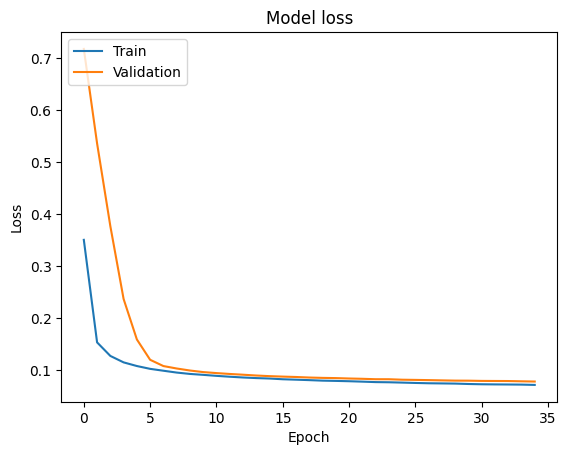

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

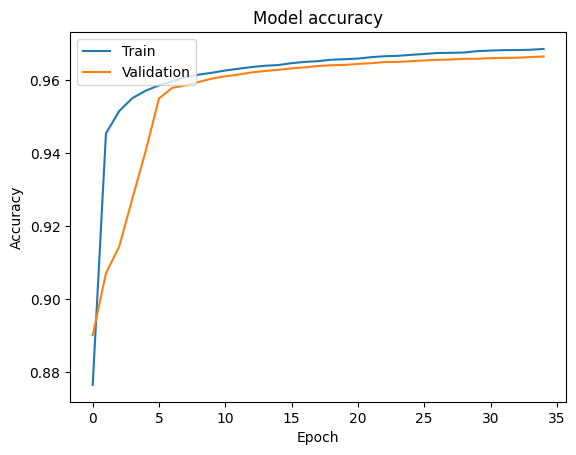

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
def inference(model, dataset, samples_to_plot):

    num_batches_to_process = 2
    count = 0
    stop_plot = False

    titles = ["Image", "GT Mask", "Pred Mask", "Overlayed Prediction"]

    for idx, data in enumerate(dataset):

        if stop_plot:
            break

        batch_img, batch_mask = data[0], data[1]
        batch_pred = (model.predict(batch_img)).astype('float32')
        batch_pred = batch_pred.argmax(axis=-1)

        batch_img  = batch_img.numpy().astype('uint8')
        batch_mask = batch_mask.numpy().squeeze(axis=-1)

        for image, mask, pred in zip(batch_img, batch_mask, batch_pred):
            count+=1
            display_image_and_mask([image, mask, pred],
                                  title_list=titles,
                                   figsize=(20,8),
                                   color_mask=True)
            if count >= samples_to_plot:
                stop_plot=True
                break

In [ ]:
inference(model, org_data, 3)

IndexError: tuple index out of range